In [1]:
from BODdata import BOD, BOD2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
x_bod = BOD[:, 0]
y_bod = BOD[:, 1]

x_bod2 = BOD2[:, 0]
y_bod2 = BOD2[:, 1]

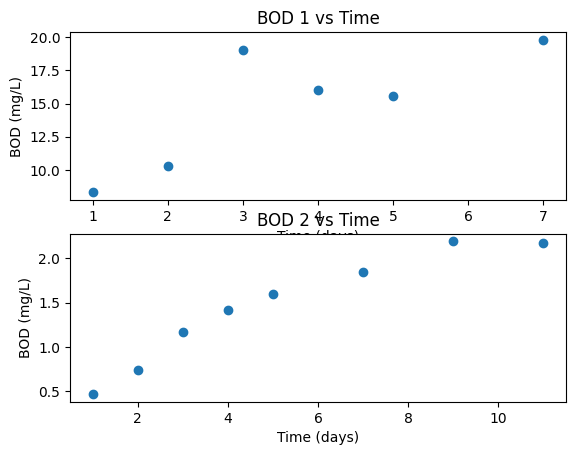

In [3]:
#Plot
fig, axs = plt.subplots(2, 1)

axs[0].plot(x_bod, y_bod, 'o')
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('BOD (mg/L)')
axs[0].set_title('BOD 1 vs Time')

axs[1].plot(x_bod2, y_bod2, 'o')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('BOD (mg/L)')
axs[1].set_title('BOD 2 vs Time')

plt.show()

In [4]:
#Make a nonlinear regression and plot the residuals
def model(t, p1, p2):
    return p1 * (1 - np.exp(-p2 * t))

popt, pcov = curve_fit(model, x_bod, y_bod)

print(f"popt: {popt}" + "\n")
print(f"pcov: {pcov}" + "\n")

residuals = y_bod - model(x_bod, *popt)
sum_of_squared_residuals = sum(residuals**2)
print(f"residuals: {residuals}")

#Vad är skillnaden?
variance = np.var(residuals, ddof=2) #vad är detta?
#variance_manual = sum_of_squared_residuals / (len(x_bod) - 2) #vad är detta?

print(f"variance: {variance}" + "\n")
#print(f"variance_manual: {variance_manual}")

popt: [19.14257663  0.53109125]

pcov: [[ 6.22977601 -0.43226011]
 [-0.43226011  0.04124   ]]

residuals: [ 0.41255027 -2.22497839  3.74832633 -0.85486963 -2.19748954  1.12242065]
variance: 6.497565340581995



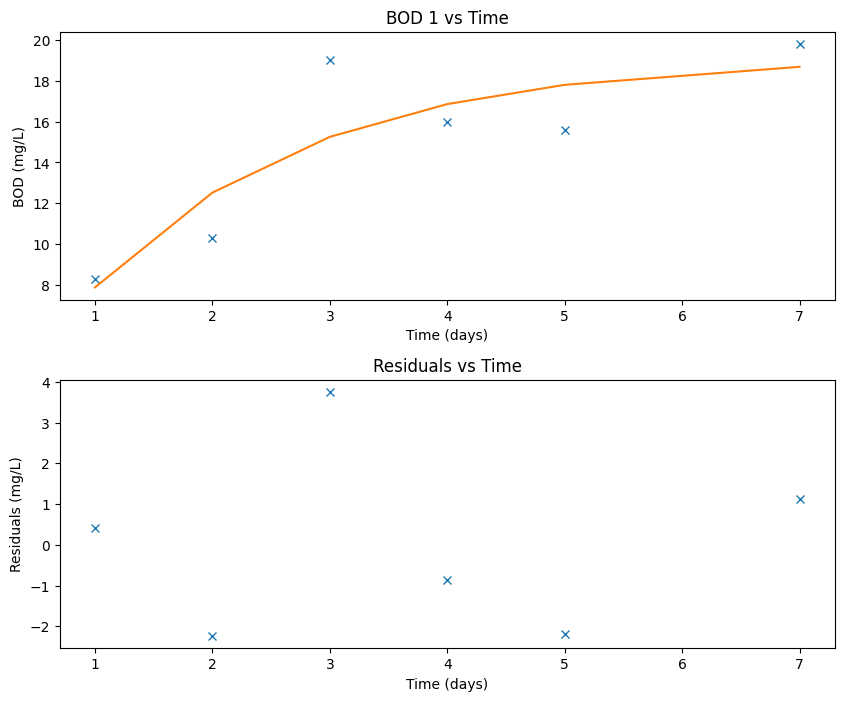

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(x_bod, y_bod, 'x')
axs[0].plot(x_bod, model(x_bod, *popt))
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('BOD (mg/L)')
axs[0].set_title('BOD 1 vs Time')

axs[1].plot(x_bod, residuals, 'x')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Residuals (mg/L)')
axs[1].set_title('Residuals vs Time')

#Set some whitespace between the plots
plt.subplots_adjust(hspace=0.3)

In [6]:
#Find the confidence interval and confidence region based on the linear approximation

def step(p1=None, p2=None):
    step = 1e-6
    
    p1_opt, p2_opt = popt
    if p1 is None and p2 is None:
        p1 = p1_opt
        p2 = p2_opt
    
    func_true = model(x_bod, p1, p2)

    p1_step = p1+step
    func_step_1 = model(x_bod, p1_step, p2)
    der_p1 = (func_step_1-func_true) / step
    
    p2_step = p2+step
    func_step_2 = model(x_bod, p1, p2_step)
    der_p2 = (func_step_2-func_true) / step


    return der_p1, der_p2
    
def calc_jacobian(p1,p2):
    j = np.column_stack(step(p1,p2))
    return j

def calc_JT_J(j):
    return j.T @ j

In [7]:
print(f"popt: {popt}" + "\n")
j_p1, j_p2 = step()

print(f"j_p1: {j_p1}" + "\n")
print(f"j_p2: {j_p2}" + "\n")

j = np.column_stack((j_p1, j_p2))
print(f"j: {j}" + "\n")

print(f"j.Tj: {j.T @ j}" + "\n")

Sp = np.sqrt(variance * np.linalg.inv(j.T @ j))
print(f"Sp: {Sp}" + "\n")

popt: [19.14257663  0.53109125]

j_p1: [0.41203699 0.65429951 0.7967409  0.88049116 0.92973323 0.97570874]

j_p2: [11.25512126 13.23518324 11.67269135  9.15080967  6.72541859  3.2549695 ]

j: [[ 0.41203699 11.25512126]
 [ 0.65429951 13.23518324]
 [ 0.7967409  11.67269135]
 [ 0.88049116  9.15080967]
 [ 0.92973323  6.72541859]
 [ 0.97570874  3.2549695 ]]

j.Tj: [[  3.8243545   40.08336518]
 [ 40.08336518 577.66295259]]

Sp: [[2.4959152       nan]
 [      nan 0.2030821]]



C:\Users\olofs\AppData\Local\Temp\ipykernel_25800\791195309.py:12: RuntimeWarning: invalid value encountered in sqrt
  Sp = np.sqrt(variance * np.linalg.inv(j.T @ j))


In [8]:
T_inv = stats.t.ppf(0.975, len(x_bod) - 2)

plus_minus = T_inv * Sp

interval_p1 = [popt[0] - plus_minus[0,0], popt[0] + plus_minus[0,0]]
interval_p2 = [popt[1] - plus_minus[1,1], popt[1] + plus_minus[1,1]]

F_inv = stats.f.ppf(0.95, 2, len(x_bod) - 2)

In [9]:

p1_points = np.linspace(interval_p1[0]*0.5,interval_p1[1]*1.5,100)
p2_points = np.linspace(interval_p2[0]*0.5,interval_p2[1]*1.5,100)

#print(f"p1_points: {p1_points}" + "\n")
#print(f"p2_points: {p2_points}" + "\n")

p1_opt, p2_opt = popt

In [10]:
valid_points = []

for p1_point in p1_points:
    for p2_point in p2_points:
        JT_J = calc_JT_J(calc_jacobian(p1_point,p2_point))
        left = (popt-np.array([p1_point, p2_point])).T @ JT_J @ (popt-np.array([p1_point, p2_point])) 
        right =  2*variance*F_inv

        if left <= right:
            valid_points.append([p1_point, p2_point])

print(f"valid_points: {valid_points}" + "\n")

valid_points: [[14.106916410741839, 0.5868165995309707], [14.106916410741839, 0.6035719918180033], [14.106916410741839, 0.6203273841050357], [14.106916410741839, 0.6370827763920682], [14.106916410741839, 0.6538381686791008], [14.106916410741839, 0.6705935609661333], [14.106916410741839, 0.6873489532531658], [14.106916410741839, 0.7041043455401984], [14.106916410741839, 0.7208597378272309], [14.106916410741839, 0.7376151301142634], [14.106916410741839, 0.754370522401296], [14.106916410741839, 0.7711259146883285], [14.106916410741839, 0.787881306975361], [14.106916410741839, 0.8046366992623936], [14.106916410741839, 0.821392091549426], [14.106916410741839, 0.8381474838364587], [14.106916410741839, 0.8549028761234911], [14.106916410741839, 0.8716582684105236], [14.106916410741839, 0.8884136606975562], [14.106916410741839, 0.9051690529845887], [14.106916410741839, 0.9219244452716212], [14.106916410741839, 0.9386798375586538], [14.106916410741839, 0.9554352298456863], [14.106916410741839, 0

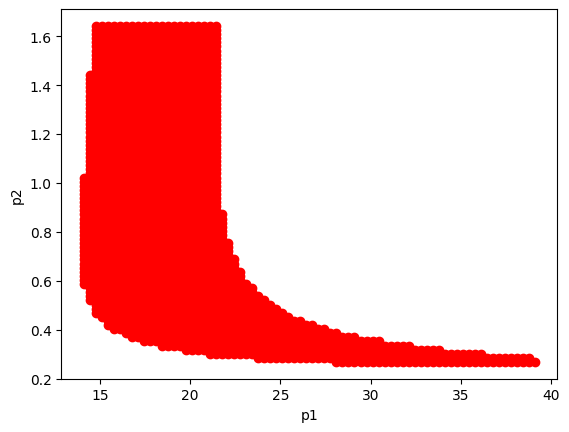

In [11]:
fig, ax = plt.subplots()
p1_points = [point[0] for point in valid_points]
p2_points = [point[1] for point in valid_points]
ax.plot(p1_points, p2_points, 'o', color='red')
ax.set_xlabel('p1')
ax.set_ylabel('p2')

plt.show()